## Macrobot Training Notebook for Asset EMU_Buxl_Fut

## Env versions (date 2021-01-22)
    - Python:  3.8.5 (default, Sep  4 2020, 07:30:14)  [GCC 7.3.0]
    - Symawofo: dev
    - Ami: dev

    - Tensorflow: 2.3.1
    - sklearn: 0.23.2
    - xgboost: 1.3.0

    - Pandas: 1.1.5
    - Dask: 2.30.0

# Set-up

## Import Standard Packages

In [1]:
import sys
sys.path.append(r'C:\ami')
sys.path.append(r'C:\SyMAWoFlo\Symawofo')
import os
import pickle
from datetime import datetime
from pathlib import Path
from macro_utils import DotDict
from symawofo.ensemble import BaggingRegressor, FeatureEnsemble
from symawofo import FeatureFrame, WindowFrame, model_selection
from symawofo.signals.wf import ThresholdSignSignal
from symawofo.pnl import PNL, AssetType
from symawofo.transformers import (
    Clipper,
    Difference,
    make_column_transformer,
    make_pipeline,
    StandardScaler,
    TransformedTargetRegressor
)
from ami.build.common import (
    make_pca_column_transformer,
    make_pca_diff_column_transformer,
    make_local_data_passthrough,
    FeatureCallable,
    make_data_splitter,
    make_preprocessing
)
from ami.macrobot.models import GRURegressor, CNNRegressor
from ami.build.loss import SampleWeightDecay, get_loss_fn



In [2]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [3]:
from symawofo import get_client
client = get_client(silence_logs=50)
client

<Client: 'tcp://127.0.0.1:52810' processes=4 threads=4, memory=25.77 GB>

   ## Tensorflow Model definition

In [4]:
from typing import Iterable

from symawofo.models.base import model
from symawofo.models.tf import BaseTFRegressor3d
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (BatchNormalization, Dense, Dropout, GRU)


@model(BaseTFRegressor3d)
class GRURegressor:
    def __init__(
            self,
            nodes=15,
            lookback_periods=13,
            activation="selu",
            kernel_initializer='random_uniform',
            regularizer_l1=0.05,
            regularizer_l2=0.0,
            recurrent_dropout=0.0,
            dropout=0.0,
            dense_units: Iterable = tuple(),
            batchnorm=True,
            batchnorm_trainable=True,
            batchnorm_training=False,
            epochs=100,
            batch_size=None,
            use_bias=False,
            recurrent_activation='hard_sigmoid',
            reset_after=False,
            implementation=1,
            **kwargs
    ):
        super().__init__(**kwargs)

        # for param in inspect.signature(self).parameters.values():
        #     setattr(self, param.name, param.default if param.name != 'dense_layers_list' else [])

        self.nodes = nodes
        self.lookback_periods = lookback_periods
        self.activation = activation
        self.kernel_initializer = kernel_initializer
        self.regularizer_l1 = regularizer_l1
        self.regularizer_l2 = regularizer_l2
        self.recurrent_dropout = recurrent_dropout
        self.dropout = dropout
        self.dense_units = dense_units
        self.batchnorm = batchnorm
        self.batchnorm_training = batchnorm_training
        self.batchnorm_trainable = batchnorm_trainable
        self.batch_size = batch_size
        self.epochs = epochs
        self.use_bias = use_bias
        self.recurrent_activation = recurrent_activation
        self.reset_after = reset_after
        self.implementation = implementation

    def _hidden_layers(self, x):
        if self.dropout:
            x = Dropout(self.dropout)(x)

        x = GRU(
            self.nodes,
            activation=self.activation,
            recurrent_dropout=self.recurrent_dropout,
            return_sequences=False,
            kernel_initializer=self.kernel_initializer,
            kernel_regularizer=regularizers.l1_l2(self.regularizer_l1, self.regularizer_l2),
            activity_regularizer=regularizers.l1(0.0),
            use_bias=self.use_bias,
            recurrent_activation=self.recurrent_activation,
            reset_after=self.reset_after,
            implementation=self.implementation
        )(x)

        dense_units = self.dense_units or []
        for n in dense_units:
            x = Dense(
                n,
                activation=self.activation,
                name=f'extra_dense{n}',
                kernel_regularizer=regularizers.l1_l2(0.01, 0.01)
            )(x)

        if self.batchnorm:
            x = BatchNormalization(trainable=self.batchnorm_trainable)(x, training=self.batchnorm_training)

        x = Dense(
            1,
            activation='linear',
            use_bias=self.use_bias,
            kernel_initializer='random_uniform',
            name='prediction'
        )(x)

        return x


    

# Feature transformation and Embeded models

In [5]:


def make_feature_transform(config: DotDict):
    tr_pca_levels = make_pca_column_transformer(config.PCA)
    tr_pca_diffs = make_pca_diff_column_transformer(config.PCA_diff)
    tr_level_features = [('passthrough', config.pass_through)]
    tr_diffs = [(Difference(1), config.diff)]
    tr_local = make_local_data_passthrough(config)

    ct = tr_pca_levels + tr_pca_diffs + tr_level_features + tr_diffs + tr_local

    return make_pipeline(
            make_column_transformer(*ct, remainder='drop'),
            StandardScaler(),
            Clipper(-config.clip_level, config.clip_level)
    )


def make_model(**kwargs):
    sample_weights_fn = SampleWeightDecay(kwargs.get('decay')) if kwargs.get('decay') else None
    if kwargs.pop('type') == 'GruModel':
        return GRURegressor(_sample_weight_fn=sample_weights_fn, **kwargs)
    else:
        return CNNRegressor(_sample_weight_fn=sample_weights_fn, **kwargs)


def get_FeatureEnsemble_params(spec):
    testing_features = spec.pop('features')
    feature_type = spec.pop('type')
    group = spec.pop('group')
    ignore_pca = spec.pop('ignore_pca')
    faulty_cond = (feature_type == ('core_features') and (group == 'combine'))
    warning = "feature_testing parameter 'group' cannot be 'combine' if feature_type is 'core_features' \nSet 'group' to 'separate' or False"
    assert not faulty_cond, warning
    if testing_features:
        features_callable = FeatureCallable(testing_features, group=group, ignore_pca=ignore_pca)
        spec[feature_type] = features_callable
    return spec


def make_ensemble_model(jobspec: DotDict):
    model = make_model(**jobspec.model)
    feature_transform = make_feature_transform(jobspec.features_transform)

    if ensemble := dict(jobspec.ensemble):
        if ensemble.pop('type') == 'bagging':
            model = BaggingRegressor(model, **ensemble)

    if feature_testing := jobspec.get('feature_testing', None):
        feature_params = get_FeatureEnsemble_params(dict(feature_testing))
        model = FeatureEnsemble(model, **feature_params)

    estimator = make_pipeline(
        feature_transform,
        model
    )
    return TransformedTargetRegressor(estimator, jobspec.target.transform)


def make_window_frame(jobspec: DotDict, data):
    target = data[jobspec.target.name]
    modeling_features = FeatureFrame(data=data)
    modeling_target = make_preprocessing(target, **jobspec.target)
    splitter = make_data_splitter(jobspec)
    targetRegressor = make_ensemble_model(jobspec)
    wf = WindowFrame(
            features=modeling_features,
            target=modeling_target,
            splitter=splitter,
            estimator=targetRegressor,
            **jobspec.windowframe
    )
    return wf


def make_signal(jobspec: DotDict, window_frame:WindowFrame):
    return ThresholdSignSignal(window_frame, **jobspec.signal)

def make_pnl(jobspec: DotDict, signal):
    return PNL(signal,
        asset_type=AssetType(log=True, level=False),
        **jobspec.trade)




# Main execution flow


##  prepare the job spec and fetch the dta

In [6]:

from ami.macrobot.runner import MacrobotRunner

from ami.macrobot.jobspec import MBJobspec

spec = MBJobspec({
    "data_splitter": {
        "expanding": 0,
        "initial_training_size": 750,
        "test_size": 13
    },
    "ensemble": {
        "agg_fn": None,
        "max_samples": None,
        "n_estimators": 2,
#         "n_jobs": -1,
        "type": "bagging",
#         "parallel_backend": "multiprocessing"
    },
    "features_transform": {
        "PCA": [
            "GLOB_Growth",
            "GLOB_Risk"
        ],
        "PCA_diff": [
            "EMU_Growth",
            "EMU_FCI"
        ],
        "clip_level": 8,
        "data_startsfrom": "2005-06-17",
        "diff": [
            "GLOB_eps_upgrade_ratio",
            "GLOB_eps",
            "EMU_eps_upgrade_ratio",
            "EMU_Equity_Vol",
            "EMU_Rate_Vol",
            "EMU_CB_Bal",
            "PCA_Var_Exp",
            "EMU_Breakeven55",
            "EMU_ForYieldSp",
            "EMU_Bond_PeriphSp",
            "GLOB_Money_UT",
            "CH_Oil_Imports_UT",
            "EMU_Buxl_Fut"
        ],
        "pass_through": [
            "EMU_Buxl_Fut_Accel",
            "EMU_Buxl_Fut_RSI",
            "EMU_EqBond_Corr",
            "GLOB_JPPMI_NE_NO_CH",
            "EUR_5_10_30_fly",
            "EMU_vs_Ger_30_weighted_Ch",
            "EMU_55yBE_vs18_plus_55yBEdiff3m_Ch"
        ]
    },
    "model": {
        "activation": "selu",
        "batch_size": 1000,
        "batchnorm": True,
        "batchnorm_trainable": True,
        "batchnorm_training": False,
        "dropout": 0.2,
        "epochs": 75,
        "lookback_periods": 26,
        "loss": "mse",
        "nodes": 10,
        "optimizer": "adam",
        "recurrent_dropout": 0.0,
        "regularizer_l1": 0.0,
        "regularizer_l2": 0.025,
        "type": "GruModel",
        "use_bias": False
    },
    "signal": {
        "c": 0.1,
        "threshold": None
    },
    "target": {
        "name": "EMU_Buxl_Fut",
        "prediction_lag": 1,
        "transform": "make_pipeline(StandardScaler(with_mean=False), Clipper(-3, 3))"
    },
    "trade": {
        "t_cost": 0.0001
    },
    "type": "MB_training",
    "windowframe": {
#         "n_jobs": -1
    }
}).parse()

runner = MacrobotRunner(spec)

data = runner.get_data()


##  build the model

In [7]:

wf = make_window_frame(spec, data)

signal = make_signal(spec, wf)

pnl = make_pnl(spec, signal)

pnl.get_pnl()

Window(training_start=10-03-2006, training_end=17-07-2020, test_start=24-07-2020, test_end=16-10-2020, offset=26)
Epoch 1/75
1/1 [==============================] - 1s 960ms/step - loss: 1.0014 - val_loss: 0.5683
Epoch 2/75
1/1 [==============================] - 0s 33ms/step - loss: 1.0002 - val_loss: 0.5673
Epoch 3/75
1/1 [==============================] - 0s 39ms/step - loss: 0.9992 - val_loss: 0.5664
Epoch 4/75
1/1 [==============================] - 0s 30ms/step - loss: 0.9983 - val_loss: 0.5655
Epoch 5/75
1/1 [==============================] - 0s 48ms/step - loss: 0.9979 - val_loss: 0.5647
Epoch 6/75
1/1 [==============================] - 0s 27ms/step - loss: 0.9957 - val_loss: 0.5638
Epoch 7/75
1/1 [==============================] - 0s 31ms/step - loss: 0.9947 - val_loss: 0.5630
Epoch 8/75
1/1 [==============================] - 0s 49ms/step - loss: 0.9944 - val_loss: 0.5623
Epoch 9/75
1/1 [==============================] - 0s 39ms/step - loss: 0.9941 - val_loss: 0.5616
Epoch 10/75


1/1 [==============================] - 0s 29ms/step - loss: 0.9942 - val_loss: 0.5598
Epoch 9/75
1/1 [==============================] - 0s 27ms/step - loss: 0.9944 - val_loss: 0.5591
Epoch 10/75
1/1 [==============================] - 0s 29ms/step - loss: 0.9932 - val_loss: 0.5584
Epoch 11/75
1/1 [==============================] - 0s 44ms/step - loss: 0.9930 - val_loss: 0.5577
Epoch 12/75
1/1 [==============================] - 0s 29ms/step - loss: 0.9922 - val_loss: 0.5570
Epoch 13/75
1/1 [==============================] - 0s 26ms/step - loss: 0.9907 - val_loss: 0.5563
Epoch 14/75
1/1 [==============================] - 0s 26ms/step - loss: 0.9902 - val_loss: 0.5556
Epoch 15/75
1/1 [==============================] - 0s 30ms/step - loss: 0.9905 - val_loss: 0.5550
Epoch 16/75
1/1 [==============================] - 0s 31ms/step - loss: 0.9896 - val_loss: 0.5544
Epoch 17/75
1/1 [==============================] - 0s 30ms/step - loss: 0.9885 - val_loss: 0.5539
Epoch 18/75
1/1 [================

1/1 [==============================] - 0s 31ms/step - loss: 0.9900 - val_loss: 0.4628
Epoch 16/75
1/1 [==============================] - 0s 30ms/step - loss: 0.9895 - val_loss: 0.4621
Epoch 17/75
1/1 [==============================] - 0s 29ms/step - loss: 0.9890 - val_loss: 0.4614
Epoch 18/75
1/1 [==============================] - 0s 25ms/step - loss: 0.9879 - val_loss: 0.4608
Epoch 19/75
1/1 [==============================] - 0s 24ms/step - loss: 0.9874 - val_loss: 0.4601
Epoch 20/75
1/1 [==============================] - 0s 31ms/step - loss: 0.9870 - val_loss: 0.4595
Epoch 21/75
1/1 [==============================] - 0s 45ms/step - loss: 0.9868 - val_loss: 0.4589
Epoch 22/75
1/1 [==============================] - 0s 30ms/step - loss: 0.9859 - val_loss: 0.4583
Epoch 23/75
1/1 [==============================] - 0s 44ms/step - loss: 0.9845 - val_loss: 0.4577
Epoch 24/75
1/1 [==============================] - 0s 32ms/step - loss: 0.9855 - val_loss: 0.4571
Epoch 25/75
1/1 [===============

1/1 [==============================] - 0s 28ms/step - loss: 0.9822 - val_loss: 0.4581
Epoch 24/75
1/1 [==============================] - 0s 33ms/step - loss: 0.9825 - val_loss: 0.4573
Epoch 25/75
1/1 [==============================] - 0s 35ms/step - loss: 0.9824 - val_loss: 0.4565
Epoch 26/75
1/1 [==============================] - 0s 30ms/step - loss: 0.9831 - val_loss: 0.4557
Epoch 27/75
1/1 [==============================] - 0s 27ms/step - loss: 0.9803 - val_loss: 0.4549
Epoch 28/75
1/1 [==============================] - 0s 44ms/step - loss: 0.9805 - val_loss: 0.4541
Epoch 29/75
1/1 [==============================] - 0s 30ms/step - loss: 0.9797 - val_loss: 0.4533
Epoch 30/75
1/1 [==============================] - 0s 28ms/step - loss: 0.9793 - val_loss: 0.4525
Epoch 31/75
1/1 [==============================] - 0s 30ms/step - loss: 0.9785 - val_loss: 0.4518
Epoch 32/75
1/1 [==============================] - 0s 43ms/step - loss: 0.9785 - val_loss: 0.4510
Epoch 33/75
1/1 [===============

1/1 [==============================] - 0s 2ms/step - loss: 0.9660
Epoch 39/75
1/1 [==============================] - 0s 5ms/step - loss: 0.9644
Epoch 40/75
1/1 [==============================] - 0s 2ms/step - loss: 0.9667
Epoch 41/75
1/1 [==============================] - 0s 3ms/step - loss: 0.9609
Epoch 42/75
1/1 [==============================] - 0s 997us/step - loss: 0.9618
Epoch 43/75
1/1 [==============================] - 0s 3ms/step - loss: 0.9611
Epoch 44/75
1/1 [==============================] - 0s 4ms/step - loss: 0.9586
Epoch 45/75
1/1 [==============================] - 0s 4ms/step - loss: 0.9637
Epoch 46/75
1/1 [==============================] - 0s 998us/step - loss: 0.9603
Epoch 47/75
1/1 [==============================] - 0s 1ms/step - loss: 0.9556
Epoch 48/75
1/1 [==============================] - 0s 998us/step - loss: 0.9652
Epoch 49/75
1/1 [==============================] - 0s 2ms/step - loss: 0.9609
Epoch 50/75
1/1 [==============================] - 0s 3ms/step - loss:

Epoch 68/75
1/1 [==============================] - 0s 2ms/step - loss: 0.9562
Epoch 69/75
1/1 [==============================] - 0s 2ms/step - loss: 0.9575
Epoch 70/75
1/1 [==============================] - 0s 3ms/step - loss: 0.9493
Epoch 71/75
1/1 [==============================] - 0s 2ms/step - loss: 0.9468
Epoch 72/75
1/1 [==============================] - 0s 4ms/step - loss: 0.9550
Epoch 73/75
1/1 [==============================] - 0s 3ms/step - loss: 0.9536
Epoch 74/75
1/1 [==============================] - 0s 3ms/step - loss: 0.9519
Epoch 75/75
1/1 [==============================] - 0s 2ms/step - loss: 0.9529
Monitor progress at http://127.0.0.1:8787/status
1/1 [==============================] - 0s 4ms/step


EMU_Buxl_Fut_Difference1_Lead1_pred_0  \
2020-07-24                               1.000000   
2020-07-31                               1.019493   
2020-08-07                               1.024107   
2020-08-14                               1.001726   
2020-08-21                               1.020647   
2020-08-28                               1.048747   
2020-09-04                               1.069574   
2020-09-11                               1.068554   
2020-09-18                               1.070632   
2020-09-25                               1.082969   
2020-10-02                               1.083308   
2020-10-09                               1.084455   
2020-10-16                               1.107030   
2020-10-23                               1.094395   
2020-10-30                               1.110512   
2020-11-06                               1.115043   
2020-11-13                               1.100803   
2020-11-20                               1.112634   
2020-11-27                               1.112898   
2020-12-04                               1.100046   
2020-12-11                               1.127280   
2020-12-18                               1.142154   
2020-12-25                               1.137257   
2021-01-01                               1.142537   
2021-01-08                               1.135106   
2021-01-15                               1.137256   

            EMU_Buxl_Fut_Difference1_Lead1_pred_1  
2020-07-24                               1.000000  
2020-07-31                               1.019493  
2020-08-07                               1.024107  
2020-08-14                               1.001726  
2020-08-21                               1.020647  
2020-08-28                               1.048747  
2020-09-04                               1.069574  
2020-09-11                               1.068554  
2020-09-18                               1.070632  
2020-09-25                               1.082969  
2020-10-02                               1.083308  
2020-10-09                               1.084455  
2020-10-16                               1.107030  
2020-10-23                               1.119625  
2020-10-30                               1.135539  
2020-11-06                               1.140070  
2020-11-13                               1.125830  
2020-11-20                               1.137661  
2020-11-27                               1.137925  
2020-12-04                               1.125073  
2020-12-11                               1.152306  
2020-12-18                               1.167180  
2020-12-25                               1.162284  
2021-01-01                               1.167564  
2021-01-08                               1.160133  
2021-01-15                               1.162283

In [8]:

pnl

In [ ]:
from ami.common.pickler import dump
dump(globals())

# Writing Results
folder_name = f'Feature_Training_{runner.jobspec.target.name}_{datetime.now().strftime("%Y-%m-%d_%H%M%S")}'
path = Path(folder_name)
path.mkdir(parents=True, exist_ok=True)
(path / 'spec.hdf5').write_bytes(pickle.dumps(runner.jobspec))
data.to_csv((path/'data.csv'))
(path / 'wf.hdf5').write_bytes(pickle.dumps(pnl.signal.wf))

# Charts

In [19]:
def chart_runs2(pnl, islog=True):
    target = get_target_from_wf(pnl.signal.wf, islog=islog)
    strat_pnl = pnl.get_pnl()
    hold_signal = pred.ThresholdSignSignal(target=target, predictions=pd.Series(1, index=strat_pnl.index[1:]), threshold=0)
    hold_pnl = quick_pnl(hold_signal, target, islog=False).get_pnl()
    ax = pnl.get_pnl().plot(figsize=(15, 10), color='grey', legend=False, alpha=0.5)
    ax.yaxis.set_ticks_position('both')
    hold_pnl.plot(ax=ax, color='blue', legend=False)
    return ax

class TrainingCharts:
    def __init__(self, pnl_comp, wf_comp)

In [18]:
print(pnl.get_pnl().first_valid_index())
print(pnl.signal.signals.first_valid_index())

2020-07-24 00:00:00
2020-07-31 00:00:00


<AxesSubplot:>

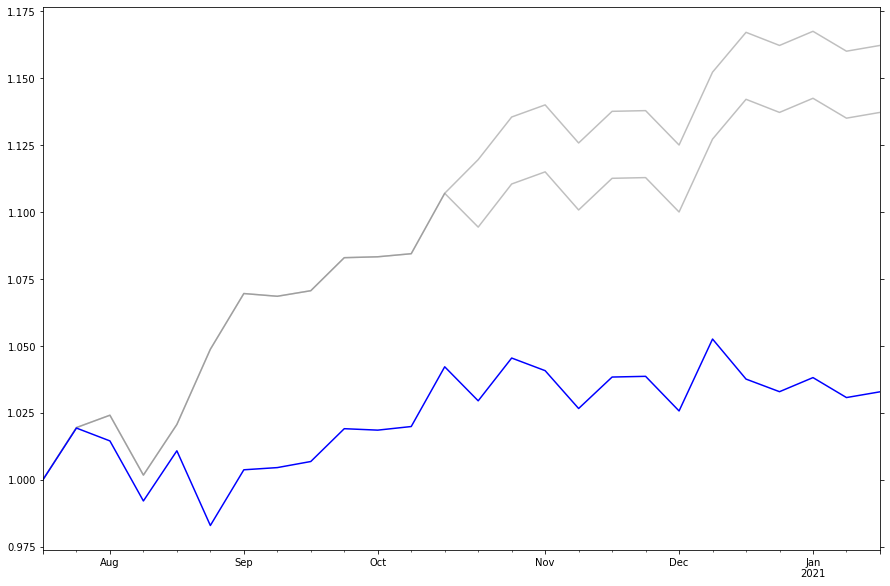

In [9]:
import ipywidgets as widgets
from ami.macrobot.charting_tools import *
logreturn = runner.jobspec.target.get('logreturn', True)

chart_runs(pnl, islog=logreturn)

<AxesSubplot:>

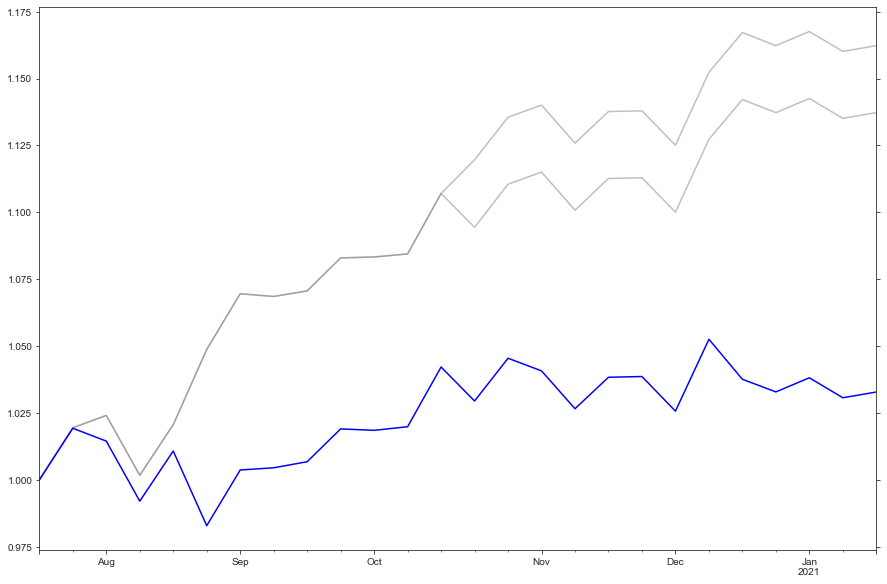

In [20]:
chart_runs2(pnl, islog=logreturn)

<AxesSubplot:>

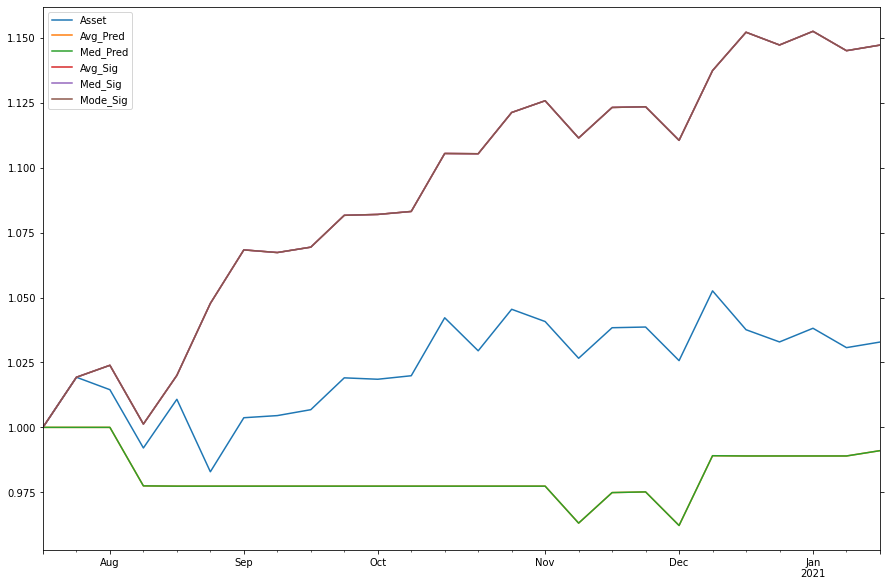

In [10]:
chart_signals(pnl.signal, runner.jobspec)

In [12]:
create_hitrate(pnl.signal, runner.jobspec, pred_agg_fn='mean')

Hitrate      Mean    Median  Share of Observations  \
Right/Signal_Up     0.5714  0.010235  0.006904                   0.16   
Wrong/Signal_Up     0.4286 -0.016571 -0.014243                   0.12   
Right/Signal_Down      NaN       NaN       NaN                   0.00   
Wrong/Signal_Down      NaN       NaN       NaN                   0.00   

                   Share of Active Signals  
Right/Signal_Up                   0.571429  
Wrong/Signal_Up                   0.428571  
Right/Signal_Down                 0.000000  
Wrong/Signal_Down                 0.000000

<AxesSubplot:ylabel='EMU_Buxl_Fut_Difference1_Lead1'>

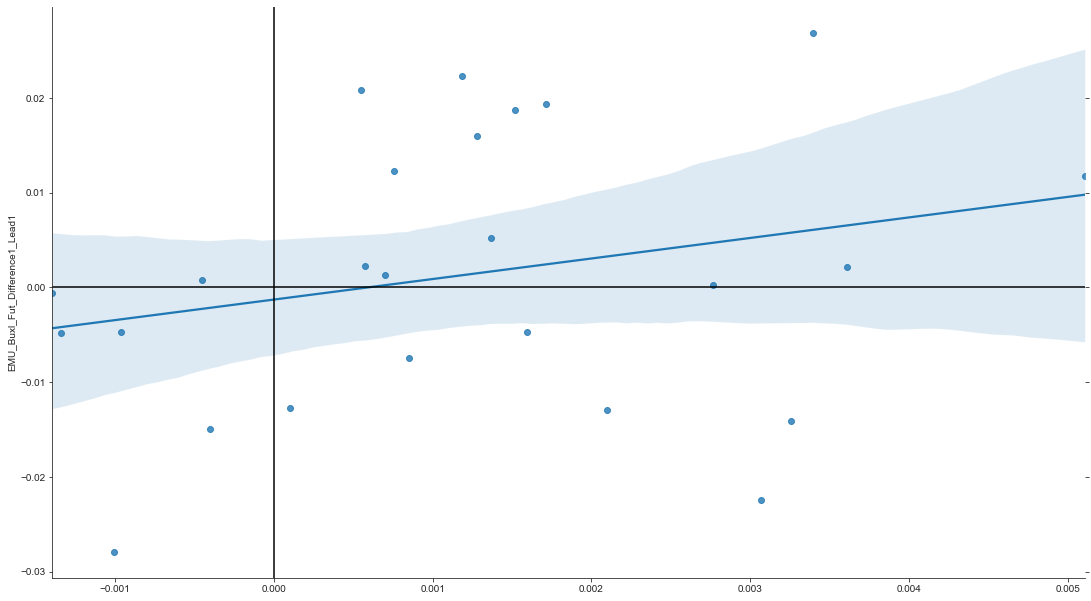

In [13]:
chart_scatter(pnl.signal, islog=logreturn)

In [14]:
dates = [w.training_end for w in pnl.signal.wf[:-1]]
results = collect_histories(pnl.signal.wf)
widgets.interactive(chart_loss, loss_dict=widgets.fixed(results), date=dates)

interactive(children=(Dropdown(description='date', options=(Timestamp('2020-07-17 00:00:00'), Timestamp('2020-…

In [15]:
widgets.interactive(chart_by_threshold, signal=widgets.fixed(pnl.signal), threshold='0.000',
                    islog=widgets.fixed(logreturn))

interactive(children=(Text(value='0.000', description='threshold'), Output()), _dom_classes=('widget-interact'…